In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from allensdk.brain_observatory.sync_dataset import Dataset
import h5py

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies import Movie, get_sync_frame_times

## Make a list of recent experiments

In [4]:
test_recs = [
    r'B:\mouse622179\estim_2022-04-14_10-20-42\experiment1\recording1',
    r'T:\zap-n-zip\EEG_exp\mouse618552\urethane_vis_2022-04-27_10-33-32\experiment1\recording1',
    r'B:\mouse622180\estim_2022-05-26_10-48-51\experiment1\recording1',
    r'T:\zap-n-zip\EEG_exp\mouse621102\estim_vis_2022-06-02_10-23-50\experiment1\recording1',
    r'T:\zap-n-zip\EEG_exp\mouse621102\opto_cortical_pilot_2022-06-03_12-09-01\experiment1\recording1',
    r'B:\mouse631538\estim_2022-06-09_11-04-32\experiment1\recording1',
    r'T:\zap-n-zip\EEG_exp\mouse627041\estim_optoTH_2022-06-23_11-50-10\experiment1\recording1',
    r'T:\zap-n-zip\EEG_exp\mouse627041\optoTH_2022-06-24_11-27-54\experiment1\recording1',
    r'B:\mouse634572\estim_2022-06-30_12-08-34\experiment1\recording1',
    r'B:\mouse638329\estim_2022-07-28_11-33-00\experiment1\recording1',
    r'B:\mouse638330\estim_2022-08-04_10-30-16\experiment1\recording1',
    r'V:\EEG_exp\mouse635397\estim_vis_2022-08-18_12-08-15\experiment1\recording1',
    r'W:\EEG_exp\mouse635397\opto_cortical_ctx_2022-08-19_11-10-25\experiment1\recording1',
]

### Loop through each one and test for pupil sync times

In [5]:
for rec_folder in test_recs:
    exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)
    exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
    
    print('\n{} -- {} ({})'.format(exp.mouse, exp_tag, exp.date))
    
    ## Load sync data ##
    sync_data = exp._load_sync_dataset()
    rising = sync_data.get_edges(keys=('eyetracking',), kind='rising', units='seconds')
    if len(rising) > 0:
        print(' This recording has pupil sync times\n')
    else:
        print(' NO pupil sync times\n')

This data does not contain an EEG recording.
Experiment type: electrical stimulation

622179 -- estim (2022-04-14 10:20:42)
 This recording has pupil sync times

Experiment type: electrical and sensory stimulation

618552 -- urethane_vis (2022-04-27 10:33:32)
 This recording has pupil sync times

This data does not contain an EEG recording.
Experiment type: electrical stimulation

622180 -- estim (2022-05-26 10:48:51)
 NO pupil sync times

Experiment type: electrical and sensory stimulation

621102 -- estim_vis (2022-06-02 10:23:50)
 NO pupil sync times

Experiment type: electrical stimulation

621102 -- opto_cortical_pilot (2022-06-03 12:09:01)
 NO pupil sync times

This data does not contain an EEG recording.
Experiment type: electrical stimulation

631538 -- estim (2022-06-09 11:04:32)
 NO pupil sync times

This data does not contain an EEG recording.
Experiment type: electrical stimulation

627041 -- estim_optoTH (2022-06-23 11:50:10)
 NO pupil sync times

This data does not contai

### Use Movie class

In [16]:
sync_file = r"T:\zap-n-zip\EEG_exp\mouse621102\opto_cortical_pilot_2022-06-03_12-09-01\experiment1\recording1\mouse621102220603120827.sync"

In [17]:
sync_data = Dataset(sync_file)

### Look for rising and falling edges in sync file

In [18]:
test_ch = 'eyetracking'
rising = sync_data.get_rising_edges(test_ch)
falling = sync_data.get_falling_edges(test_ch)

In [19]:
print(len(rising))
print(len(falling))

0
0


In [7]:
sync_data.meta_data['ni_daq']['counter_output_freq']

100000.0

In [8]:
sync_ch = 'eyetracking' # sync channel name? for sync timestamps?

In [9]:
print(sync_data.line_labels)

['barcodes', 'opto_sync', 'frames', 'behavior_sweep', 'photodiode', 'sweep', '', 'behavior_vsync', 'eyetracking', 'behavior', 'rotA', 'rotB', 'estim_sync', 'estim_sweep', '', '', '', 'opto_sweep', 'opto_trial', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [10]:
movie_class = Movie(filepath=movie_filepath, sync_filepath=sync_file, sync_channel='eyetracking')

C:\Users\lesliec\code\tbd_eeg\tbd_eeg\data_analysis\Utilities\behavior_movies.py:116: UserWarning: channel eyetracking in sync file is empty
  'channel {} in sync file is empty'.format(channel_name))


In [12]:
movie_class.frame_count

265638

In [13]:
movie_class.width

640

In [14]:
movie_class.height

480

In [13]:
help(movie_class)

Help on Movie in module tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies object:

class Movie(builtins.object)
 |  a class for loading movies captured with videomon
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filepath, sync_filepath=None, sync_channel=None, edge='rising', sync_timestamps=None, h5_filename=None, lazy_load=True)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_frame(self, frame=None, time=None, timestamps='sync')
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



#### Give the movie object a time (in the master clock) and it will find the correct frame.

In [38]:
testframe = movie_class.get_frame(frame=0)

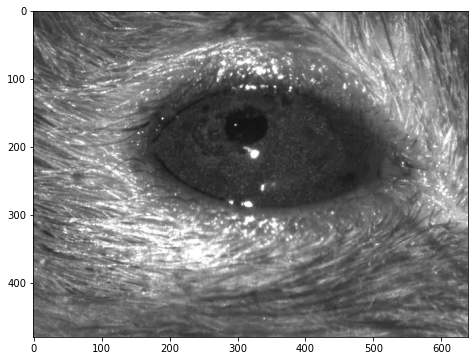

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(testframe)

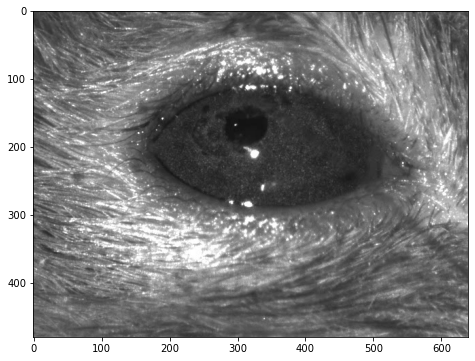

In [42]:
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(movie_class.get_frame(frame=15))

#### The code example I followed just looped through the relevant times and grabbed the nearest frame in time using the movie.get_frame(time=time_i) functions.

In [15]:
help(movie_class.get_frame)

Help on method get_frame in module tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies:

get_frame(frame=None, time=None, timestamps='sync') method of tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies.Movie instance



In [16]:
dir(movie_class)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_array',
 '_lazy_load',
 'array',
 'cap',
 'frame_count',
 'get_frame',
 'height',
 'sync_timestamps',
 'timestamps_from_file',
 'width']

In [17]:
syncts = movie_class.sync_timestamps

In [19]:
syncts

In [18]:
1/np.mean(np.diff(syncts))

29.96210520977723

In [28]:
movie_class.frame_count

107958

In [51]:
testts = get_sync_frame_times(sync_data, sync_ch, edge='rising', first_index=0, threshold=0.001, clean=True, verbose=False)

In [52]:
len(testts)

42021

## Load the h5 file

In [20]:
timestamp_file = h5py.File(movie_filepath.replace('.avi','.h5'), 'r')

In [21]:
timestamp_file.keys()

<KeysViewHDF5 ['camera_config', 'frame_intervals', 'video_metadata']>

In [22]:
print(timestamp_file['camera_config'])

<HDF5 dataset "camera_config": shape (), type "|S2">


In [23]:
help(timestamp_file)

Help on File in module h5py._hl.files object:

class File(h5py._hl.group.Group)
 |  Represents an HDF5 file.
 |  
 |  Method resolution order:
 |      File
 |      h5py._hl.group.Group
 |      h5py._hl.base.HLObject
 |      h5py._hl.base.CommonStateObject
 |      h5py._hl.base.MutableMappingHDF5
 |      h5py._hl.base.MappingHDF5
 |      collections.abc.MutableMapping
 |      collections.abc.Mapping
 |      collections.abc.Collection
 |      collections.abc.Sized
 |      collections.abc.Iterable
 |      collections.abc.Container
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, *args)
 |  
 |  __init__(self, name, mode=None, driver=None, libver=None, userblock_size=None, swmr=False, rdcc_nslots=None, rdcc_nbytes=None, rdcc_w0=None, track_order=None, **kwds)
 |      Create a new file object.
 |      
 |      See the h5py user guide for a detailed explanation of the options.
 |      
 |      name
 |          Name of the file on disk, o

In [24]:
video_ts = np.hstack((0, np.cumsum(timestamp_file['frame_intervals'])))

In [25]:
video_ts[0:5]

array([0.        , 0.03336675, 0.06678763, 0.100051  , 0.13324465])

In [26]:
1/np.mean(np.diff(video_ts[0:5]))

30.019966623610745

In [27]:
len(video_ts)

107958